# L2B vertical resampling/interpolation
## Vertical resampling and interpolation of the Aeolus scientific wind product (L2B)

> Authors: Isabell Krisch
>
> Abstract: Access to level 2B product, rearanging of the data into profiles, and interpolation to a regular altitude grid. The interpolation to a regular altitude grid takes about 5min for 3 variables and one week of Aeolus data.

## Load packages, modules and extensions

In [1]:
# %load_ext blackcellmagic
# enable following line for interactive visualization backend for matplotlib
# %matplotlib widget
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.18.0

viresclient: 0.11.3
pandas     : 2.1.3
xarray     : 2023.12.0
matplotlib : 3.8.2



In [2]:
from viresclient import AeolusRequest
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Load Aeolus data
> For details on how to read Aeolus L2B data see Notebook Demo-ALD_U_N_2B. 

> This notbook only uses Rayleigh clear measurements. By adjusting the following section one could retrieve other data products and do the same e.g. also with Mie cloudy data.

In [3]:
# Aeolus product
DATA_PRODUCT = "ALD_U_N_2B"

# measurement period in yyyy-mm-ddTHH:MM:SS
measurement_start = "2019-09-11T22:00:00Z"
measurement_stop = "2019-09-12T00:00:00Z"

# define fields to retrieve
rayleigh_wind_fields = [
    "rayleigh_wind_result_start_time",
    "rayleigh_wind_result_stop_time",
    "rayleigh_wind_result_COG_altitude",
    "rayleigh_wind_result_wind_velocity",
    "rayleigh_wind_result_reference_hlos",
    "rayleigh_wind_result_HLOS_error",
    "rayleigh_wind_result_id",
    "rayleigh_wind_result_observation_type",
    "rayleigh_wind_result_validity_flag",
]

rayleigh_profile_fields = [
    "rayleigh_wind_profile_wind_result_id",
    "rayleigh_wind_profile_observation_type",
    "rayleigh_profile_datetime_average",
    "rayleigh_profile_alt_of_DEM_intersection",
    "rayleigh_profile_lat_of_DEM_intersection",
    "rayleigh_profile_lon_of_DEM_intersection",
]

# get L2B data
request = AeolusRequest()
request.set_collection(DATA_PRODUCT)
request.set_fields(
    rayleigh_wind_fields=rayleigh_wind_fields, rayleigh_profile_fields=rayleigh_profile_fields
)

L2B_rayleigh = request.get_between(
    start_time=measurement_start, end_time=measurement_stop, filetype="nc", asynchronous=True
).as_xarray()

# load data from dask array into storage. This line speeds up the code below a lot.
L2B_rayleigh = L2B_rayleigh.load()

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.793MB)

## Select only Rayleigh clear data

In [4]:
f_clear_p = L2B_rayleigh["rayleigh_wind_profile_observation_type"] == 2
f_clear = L2B_rayleigh["rayleigh_wind_result_observation_type"] == 2
L2B_rayleigh_clear = L2B_rayleigh.isel(rayleigh_profile_data=f_clear_p, rayleigh_wind_data=f_clear)

## Reshape the data into 2D arrays (profile vs. range bin)

In [5]:
def reshape_to_profile(data, mtype="rayleigh"):
    """
    Input:   data      xarray.Dataset containing Aeolus L2B wind data.
                       It needs to contain the parameters wind_result_id and wind_profile_wind_result_id
             mtype     Measurement type (Rayleigh or Mie)

    Output:  data_2D   xarray.Dataset containing all variables from data resampled into 2D (profile vs. range-bin)
    """
    # get data shape of (new) 2D array
    data_shape = data[mtype + "_wind_profile_wind_result_id"].shape
    # get wind ids from 1D dataset
    wind_result_id = data[mtype + "_wind_result_id"].astype(np.int32)
    # get wind ids per profile and reshape to 1D
    new_wind_result_id = data[mtype + "_wind_profile_wind_result_id"].values.flatten()
    mask = new_wind_result_id == 0

    # increment all ambigious wind ids (necessary if multiple L2B files were concatenated by the request)
    while (np.diff(wind_result_id) < 0).sum() > 0:
        i = np.where(np.diff(wind_result_id) < 0)[0][0]
        increment = -np.diff(wind_result_id)[i] + 1
        ip = np.where(new_wind_result_id == wind_result_id[i].values)[0][0]
        wind_result_id[i + 1 :] += increment
        new_wind_result_id[ip + 1 :] += increment
    new_wind_result_id[mask] = 0

    # populate wind ids with incremented values and reindex all 1D DataArrays to 2D (still on 1D)
    data[mtype + "_wind_result_id"] = wind_result_id
    data_1D = (
        data.drop_dims(mtype + "_profile_data")
        .set_index({mtype + "_wind_data": "rayleigh_wind_result_id"})
        .reindex({mtype + "_wind_data": new_wind_result_id})
    )

    # reshape to 2D and reinclude all original 2D DataArrays
    midx = pd.MultiIndex.from_product(
        [range(1, data_shape[0] + 1), range(1, data_shape[1] + 1)],
        names=("rayleigh_profile_data", "array_24"),
    )
    data_1D[mtype + "_wind_data"] = midx
    data_2D = xr.merge(
        [data.drop_dims(mtype + "_wind_data"), data_1D.unstack(dim=mtype + "_wind_data")]
    )
    return data_2D

In [6]:
%%time
L2B_rayleigh_clear_2D = reshape_to_profile(L2B_rayleigh_clear, mtype="rayleigh")

# discard all duplicate profiles (duplicates may occure in neighbouring orbits due to downlinking procedure)
_, profile_index = np.unique(
    L2B_rayleigh_clear_2D["rayleigh_profile_datetime_average"], return_index=True
)
L2B_rayleigh_clear_2D = L2B_rayleigh_clear_2D.isel(rayleigh_profile_data=profile_index)

CPU times: user 216 ms, sys: 44.3 ms, total: 260 ms
Wall time: 260 ms


(25.0, 0.0)

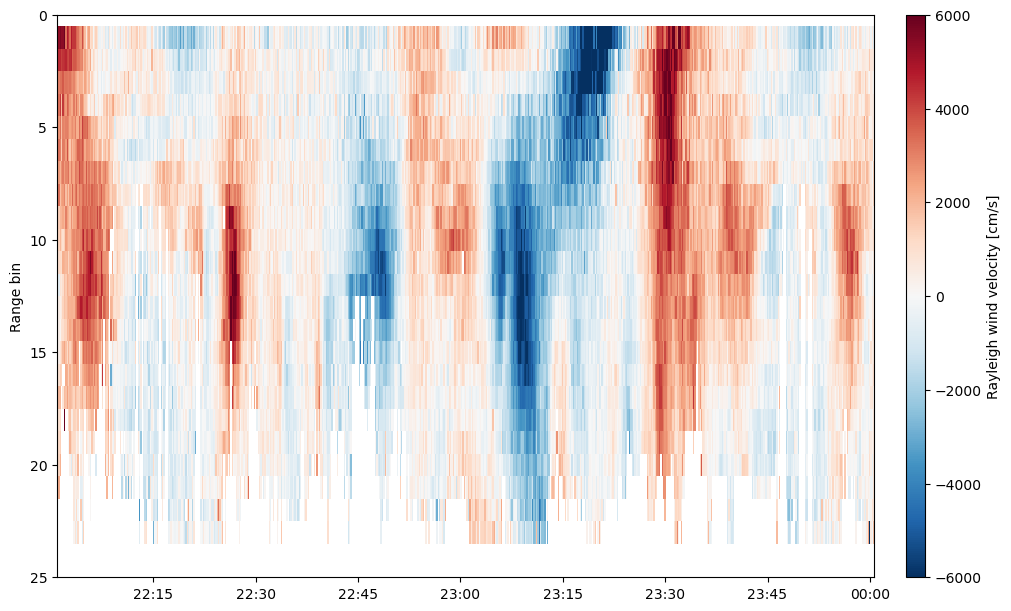

In [7]:
# plot curtain of 2D data
plot_data = xr.decode_cf(L2B_rayleigh_clear_2D, decode_times=True)
ee_QC_filter = plot_data["rayleigh_wind_result_HLOS_error"] < 800
fig, ax = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)
p = ax.pcolormesh(
    plot_data["rayleigh_profile_datetime_average"],
    plot_data["array_24"],
    plot_data["rayleigh_wind_result_wind_velocity"].where(ee_QC_filter).T,
    shading="auto",
    vmin=-6000,
    vmax=6000,
    cmap="RdBu_r",
)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.autoscale()
units = plot_data["rayleigh_wind_result_wind_velocity"].units
fig.colorbar(p, ax=ax, aspect=30, pad=0.02, label="Rayleigh wind velocity [{:s}]".format(units))
ax.set_ylabel("Range bin")
ax.set_ylim(25, 0)

## Interpolate Aeolus data to a regular altitude grid

In [8]:
def interpolate_to_altitude(
    data,
    altitudes=np.arange(0, 30000, 1000),
    mtype="rayleigh",
    variables=["rayleigh_wind_result_wind_velocity"],
    altitude_name="rayleigh_wind_result_COG_altitude",
):
    """
    Input:   data           xarray.Dataset containing Aeolus L2B wind data on a 2D array
                            (profile vs range-bin).
             altitude       numpy.Array containing the new altitude grid (in meter)
             mtype          Measurement type (Rayleigh or Mie)
             variables      List or None: Names of variables to interpolate to the new grid. None will interpolate all variables.
             altitude_name  Name of altitude variable in input dataset (used for interpolation)

    Output:  data_alt   xarray.Dataset containing all variables from data resampled into 2D (profile vs. range-bin)
    """
    # create a xarray.DataArray with given altitudes
    new_alts = xr.DataArray(
        data=altitudes, name=mtype + "_altitude", dims=[mtype + "_altitude"], attrs={"units": "m"}
    )
    
    # remove unecessary variables before interpolation
    if variables is not None:
        # save all 1D variables for later
        data_1D = data.drop_dims("array_24")
        # remove all unnecessary variables for processing
        variables.append(altitude_name)
        dims = list(data.dims)
        for var in list(data.variables):
            if var not in (dims + variables):
                data = data.drop_vars(var)    

    # fill the new DataSet with all reinterpolated variables variables
    results = []
    for t_label, t_group in data.groupby(mtype + "_profile_data"):
        results.append(t_group.squeeze().dropna(dim="array_24").set_index({"array_24": altitude_name}).interp(array_24=new_alts))
    data_alt = xr.concat(results, dim=mtype + "_profile_data_bins")
    data_alt = data_alt.rename({mtype + "_profile_data_bins": mtype + "_profile_data", "array_24": mtype + "_altitude"})
    
    # re-add 1D variables to DataSet (if they have been removed before)
    if variables is not None:
        data_alt = xr.merge([data_alt, data_1D])

    return data_alt

In [9]:
%%time
L2B_rayleigh_clear_2D_reg_alt = interpolate_to_altitude(
    L2B_rayleigh_clear_2D,
    altitudes=np.arange(0, 30000, 1000),
    mtype="rayleigh",
    variables=[
        "rayleigh_wind_result_wind_velocity",
        "rayleigh_wind_result_reference_hlos",
        "rayleigh_wind_result_HLOS_error",
    ],
    altitude_name="rayleigh_wind_result_COG_altitude",
)

CPU times: user 2.24 s, sys: 26.2 ms, total: 2.26 s
Wall time: 2.27 s


/tmp/ipykernel_1241/428852928.py:39: UserWarning: rename 'rayleigh_profile_data_bins' to 'rayleigh_profile_data' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_alt = data_alt.rename({mtype + "_profile_data_bins": mtype + "_profile_data", "array_24": mtype + "_altitude"})
/tmp/ipykernel_1241/428852928.py:39: UserWarning: rename 'array_24' to 'rayleigh_altitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_alt = data_alt.rename({mtype + "_profile_data_bins": mtype + "_profile_data", "array_24": mtype + "_altitude"})


Text(0, 0.5, 'Altitude [m]')

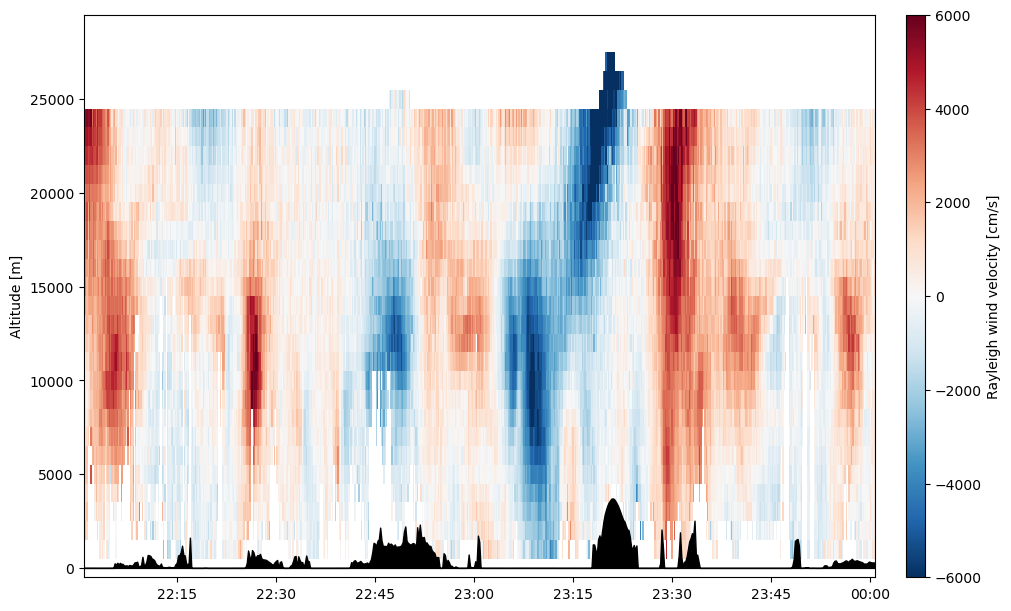

In [10]:
# plot curtain of 2D data on regular altitude grid
plot_data = xr.decode_cf(L2B_rayleigh_clear_2D_reg_alt, decode_times=True)
ee_QC_filter = plot_data["rayleigh_wind_result_HLOS_error"] < 800
fig, ax = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)
p = ax.pcolormesh(
    plot_data["rayleigh_profile_datetime_average"],
    plot_data["rayleigh_altitude"],
    plot_data["rayleigh_wind_result_wind_velocity"].where(ee_QC_filter).T,
    shading="auto",
    vmin=-6000,
    vmax=6000,
    cmap="RdBu_r",
)
ax.fill_between(
    plot_data["rayleigh_profile_datetime_average"],
    plot_data["rayleigh_profile_alt_of_DEM_intersection"],
    color="k",
)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.autoscale()
units = plot_data["rayleigh_wind_result_wind_velocity"].units
fig.colorbar(p, ax=ax, aspect=30, pad=0.02, label="Rayleigh wind velocity [{:s}]".format(units))
alt_units = plot_data["rayleigh_altitude"].units
ax.set_ylabel("Altitude [{:s}]".format(alt_units))